In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.metrics import classification_report

In [27]:
df = pd.read_csv("C:\\Users\\Prakhar\\Desktop\\Accident_Information.csv\\Accident_Information.csv")
#df.shape()
#df.head()
#df.info()
#df.describe().T

In [28]:
df2 = pd.read_csv("C:\\Users\\Prakhar\\Desktop\\Vehicle_Information.csv\\Vehicle_Information.csv", encoding='ISO-8859-1')
#df2.head()
#df2.shape()
#df2.info()
#df2.describe().T
#df2.isna().sum()

In [29]:
df['Hour'] = df['Time'].str[0:2]
df['Hour'] = pd.to_numeric(df['Hour'])
df = df.dropna(subset=['Hour'])
df['Hour'] = df['Hour'].astype('int')

def time_conversion(hour):
    if hour >= 5 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 15:
        return "2"
    elif hour >= 15 and hour < 19:
        return "3"
    elif hour >= 19 and hour < 23:
        return "4"
    else:
        return "5"

In [30]:
daytime_groups = {1: 'Morning: Between 5 and 10', 
                  2: 'Office Hours: Between 10 and 15', 
                  3: 'Afternoon Rush: Between 15 and 19', 
                  4: 'Evening: Between 19 and 23', 
                  5: 'Night: Between 23 and 5'}



df['Daytime'] = df['Hour'].apply(time_conversion)
df[['Time', 'Hour', 'Daytime']].head()

df = df.drop(columns=['Time', 'Hour'])
# print('Proportion of Missing Values in df :',round(df.isna().sum().sum()/len(df), 3), '%')


In [31]:
df.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Daytime
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,2005-01-04,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,Urban,Raining no high winds,2005,No,3
1,200501BS00002,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,None,30.0,Urban,Fine no high winds,2005,No,3
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,Urban,Fine no high winds,2005,No,5
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,Urban,Fine no high winds,2005,No,2
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,Urban,Fine no high winds,2005,No,4


In [32]:
df = df.drop(columns=['2nd_Road_Class', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident',
                                    'Location_Easting_OSGR', 'Location_Northing_OSGR', 
                                    'LSOA_of_Accident_Location',
                                    'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
                                    'InScotland'])

df = df.dropna()
df.isna().sum().sum()

0

In [33]:
df3 = pd.merge(df[['Accident_Index', 'Accident_Severity', 'Daytime', 'Speed_limit', 'Urban_or_Rural_Area',"Latitude","Longitude"]], 
              df2[['Accident_Index', 'Age_Band_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 
                        'Engine_Capacity_.CC.', 'Vehicle_Manoeuvre']], 
              on='Accident_Index')

# df3.isna().sum()
df3 = df3.dropna()
# df3.isna().sum().sum()
#df.info()    

In [34]:
for col in ['Accident_Severity', 'Daytime', 'Speed_limit', 'Urban_or_Rural_Area',
            'Age_Band_of_Driver', 'Sex_of_Driver', 'Vehicle_Manoeuvre']:
    df3[col] = df3[col].astype('category')
    
#df3.info()

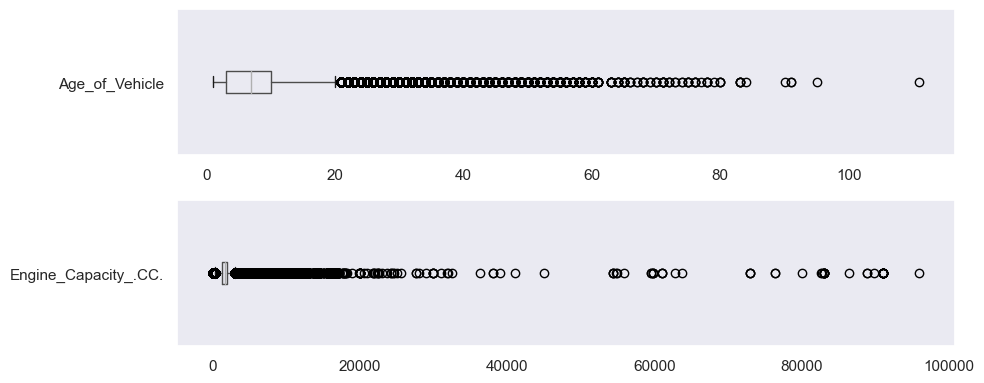

In [35]:
num_cols = ['Age_of_Vehicle', 'Engine_Capacity_.CC.']
sns.set(style='darkgrid')
fig, axes = plt.subplots(2,1, figsize=(10,4))

for ax, col in zip(axes, num_cols):
    df3.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout();

#df3['Engine_Capacity_.CC.'].describe()

In [36]:
condition = (df3['Engine_Capacity_.CC.'] < 20000)
df3 = df3[condition]

#df3['Age_of_Vehicle'].describe()


age_of_vehicle_bins = {1: '1 to <2 years', 
                       2: '2 to <3 years', 
                       3: '3 to <7 years', 
                       4: '7 to <10 years', 
                       5: '>=10 years'}

In [37]:
df3['Age_of_Vehicle'] = np.digitize(df3['Age_of_Vehicle'], bins=[1,2,3,7,10])
df3['Age_of_Vehicle'] = df3['Age_of_Vehicle'].astype('category')
df3['Age_of_Vehicle'].value_counts().sort_index()

1    167809
2    150185
3    529315
4    356323
5    500339
Name: Age_of_Vehicle, dtype: int64

In [49]:
num_cols = ['Engine_Capacity_.CC.',"Latitude","Longitude"]
cat_cols = ['Daytime', 'Speed_limit', 'Urban_or_Rural_Area',
            'Age_Band_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 'Vehicle_Manoeuvre']
target_col = ['Accident_Severity']

cols = cat_cols + num_cols + target_col
df_model = df3[cols].copy()
df_model.shape

(1703971, 11)

In [54]:
dummies = pd.get_dummies(df_model[cat_cols], drop_first=True)
df_model = pd.concat([df_model[num_cols], df_model[target_col], dummies], axis=1)
#df_model.shape
#df_model.isna().sum().sum()
features = df_model.drop(['Accident_Severity'], axis=1)
target = df_model[['Accident_Severity']]

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
df_model['Accident_Severity'].value_counts(normalize=True)


Slight     0.859267
Serious    0.127225
Fatal      0.013508
Name: Accident_Severity, dtype: float64

In [56]:
test_lats=X_test["Latitude"]
test_longs=X_test["Longitude"]

In [57]:
X_train = X_train.drop(['Longitude', 'Latitude'], axis=1)


In [58]:
X_test = X_test.drop(['Longitude', 'Latitude'], axis=1)


In [ ]:
del accidents
del vehicles 


# forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1, class_weight='balanced')
# forest_1.fit(X_train, y_train)
# y_test_preds  = forest_1.predict(X_test)
# report = classification_report(y_test, y_test_preds)
# print('Classification Report Random Forest - with Entropy and class_weight Parameter: \n', report)

In [60]:
#type(y_train)
label_encoder = preprocessing.LabelEncoder()
y_train_nn = label_encoder.fit_transform(y_train)
y_test_nn = label_encoder.fit_transform(y_test)
x_train_ann = X_train.astype("float32")/255
x_test_ann = X_test.astype("float32")/255

num_classes = 3
y_train_ann = utils.to_categorical(y_train_nn, num_classes)
y_test_ann = utils.to_categorical(y_test_nn, num_classes)
num_features = x_test_ann.shape[1]
num_classes = y_train_ann.shape[1]

In [70]:
# unique_categories = label_encoder.classes_
# print("Unique categories:", unique_categories)

# # Display the encoded labels for each unique category
# encoded_labels = label_encoder.transform(unique_categories)
# category_label_mapping = dict(zip(unique_categories, encoded_labels))
# print("Category label mapping:", category_label_mapping)

Unique categories: ['Fatal' 'Serious' 'Slight']
Category label mapping: {'Fatal': 0, 'Serious': 1, 'Slight': 2}


In [61]:
ann_model3 = tf.keras.Sequential()
ann_model3.add(Dense(512, kernel_initializer='normal', activation='relu', input_shape=(50,)))

ann_model3.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

ann_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
history3 = ann_model3.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
6816/6816 [==============================] - 42s 4ms/step - loss: 0.4399 - accuracy: 0.8590 - val_loss: 0.4305 - val_accuracy: 0.8592
Epoch 2/20
6816/6816 [==============================] - 18s 3ms/step - loss: 0.4287 - accuracy: 0.8593 - val_loss: 0.4279 - val_accuracy: 0.8592
Epoch 3/20
6816/6816 [==============================] - 19s 3ms/step - loss: 0.4275 - accuracy: 0.8594 - val_loss: 0.4258 - val_accuracy: 0.8591
Epoch 4/20
6816/6816 [==============================] - 18s 3ms/step - loss: 0.4269 - accuracy: 0.8593 - val_loss: 0.4309 - val_accuracy: 0.8592
Epoch 5/20
6816/6816 [==============================] - 19s 3ms/step - loss: 0.4266 - accuracy: 0.8594 - val_loss: 0.4254 - val_accuracy: 0.8592
Epoch 6/20
6816/6816 [==============================] - 19s 3ms/step - loss: 0.4264 - accuracy: 0.8593 - val_loss: 0.4262 - val_accuracy: 0.8592
Epoch 7/20
6816/6816 [==============================] - 18s 3ms/step - loss: 0.4261 - accuracy: 0.8594 - val_loss: 0.4253 - val_ac

In [63]:
score3 = ann_model3.evaluate(x_test_ann, y_test_ann, verbose=1)
print('Test loss: ', score3[0])
print('Test Accuracy:: ', score3[1])

10650/10650 [==============================] - 15s 1ms/step - loss: 0.4246 - accuracy: 0.8592
Test loss:  0.4245552122592926
Test Accuracy::  0.8592027425765991


In [64]:
ann_model_json = ann_model3.to_json()
with open("ann_model3.json", "w") as json_file:
    json_file.write(ann_model_json)
# serialize weights to HDF5
ann_model3.save_weights("C:\\Users\\Prakhar\\Desktop\\ann_model3.h5")
print("Saved model to disk")

Saved model to disk


In [65]:
y_pred_ann  = ann_model3.predict(x_test_ann)
y_pred_ann = np.apply_along_axis(np.argmax, 1, y_pred_ann)

10650/10650 [==============================] - 25s 1ms/step


In [66]:
print(classification_report(y_test_nn, y_pred_ann))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4569
           1       0.46      0.01      0.01     43431
           2       0.86      1.00      0.92    292795

    accuracy                           0.86    340795
   macro avg       0.44      0.34      0.31    340795
weighted avg       0.80      0.86      0.80    340795



In [107]:
# test_lats=pd.DataFrame(test_lats)
# test_longs=pd.DataFrame(test_longs)
# test_lats = test_lats.reset_index(drop=True)
# test_longs = test_longs.reset_index(drop=True)
# df_y_pred=pd.DataFrame(y_pred_ann)
# df_y_pred = df_y_pred.reset_index(drop=True)
# df_y_pred.isna().sum()
# combined_df = pd.concat([test_lats, test_longs, df_y_pred], axis=1,ignore_index=True)

# # Optional: Rename the columns if needed
# combined_df.columns = ['latitude', 'longitude', 'y_pred']

In [108]:
****************************************************************************

In [111]:
# combined_df.head()

,latitude,longitude,y_pred
0,50.894200,-1.262879,2
1,51.712308,-0.221795,2
2,54.895514,-5.021088,2
3,51.352165,-0.158367,2
4,52.754220,-2.376460,2


In [116]:
# unique_values = combined_df['y_pred'].unique()


In [117]:
# unique_values

array([2, 1], dtype=int64)

In [112]:
# df_class1 = combined_df[combined_df['y_pred'] == 1]
# df_class2 = combined_df[combined_df['y_pred'] == 2]
# df_class3 = combined_df[combined_df['y_pred'] == 3]

In [115]:
# df_class1.to_csv('C:\\Users\\Prakhar\\Desktop\\class1.csv', index=False)
# df_class2.to_csv('C:\\Users\\Prakhar\\Desktop\\class2.csv', index=False)
# df_class3.to_csv('C:\\Users\\Prakhar\\Desktop\\class3.csv', index=False)


In [25]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization

# Assuming `num_classes` is defined
# ann_model3 = Sequential()
# ann_model3.add(Dense(512, kernel_initializer='normal', activation='relu', input_shape=(50,)))
# ann_model3.add(BatchNormalization())  # Batch Normalization layer
# ann_model3.add(Dense(256, kernel_initializer='normal', activation='relu'))
# ann_model3.add(BatchNormalization())  # Batch Normalization layer
# ann_model3.add(Dense(128, kernel_initializer='normal', activation='relu'))
# ann_model3.add(BatchNormalization())  # Batch Normalization layer

# ann_model3.add(Dense(3, kernel_initializer='normal', activation='softmax'))

# ann_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [26]:
# history3 = ann_model3.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
6816/6816 [==============================] - 211s 8ms/step - loss: 0.4378 - accuracy: 0.8575 - val_loss: 0.5708 - val_accuracy: 0.8597
Epoch 2/20
6816/6816 [==============================] - 52s 8ms/step - loss: 0.4285 - accuracy: 0.8590 - val_loss: 0.5874 - val_accuracy: 0.8552
Epoch 3/20
6816/6816 [==============================] - 48s 7ms/step - loss: 0.4273 - accuracy: 0.8590 - val_loss: 0.5597 - val_accuracy: 0.8597
Epoch 4/20
6816/6816 [==============================] - 47s 7ms/step - loss: 0.4265 - accuracy: 0.8591 - val_loss: 0.5070 - val_accuracy: 0.8597
Epoch 5/20
6816/6816 [==============================] - 45s 7ms/step - loss: 0.4259 - accuracy: 0.8591 - val_loss: 0.5799 - val_accuracy: 0.8597
Epoch 6/20
6816/6816 [==============================] - 46s 7ms/step - loss: 0.4257 - accuracy: 0.8591 - val_loss: 0.5309 - val_accuracy: 0.8597
Epoch 7/20
6816/6816 [==============================] - 46s 7ms/step - loss: 0.4253 - accuracy: 0.8592 - val_loss: 0.8298 - val_a


KeyboardInterrupt



In [ ]:
# y_pred_ann  = ann_model3.predict(x_test_ann)
# y_pred_ann = np.apply_along_axis(np.argmax, 1, y_pred_ann)

In [ ]:
# print(classification_report(y_test_nn, y_pred_ann))

In [68]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1703971 entries, 0 to 2058070
Data columns (total 52 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   Engine_Capacity_.CC.                                   float64
 1   Latitude                                               float64
 2   Longitude                                              float64
 3   Daytime_2                                              uint8  
 4   Daytime_3                                              uint8  
 5   Daytime_4                                              uint8  
 6   Daytime_5                                              uint8  
 7   Speed_limit_15.0                                       uint8  
 8   Speed_limit_20.0                                       uint8  
 9   Speed_limit_30.0                                       uint8  
 10  Speed_limit_40.0                                       uint8  
 11

10650/10650 [==============================] - 15s 1ms/step


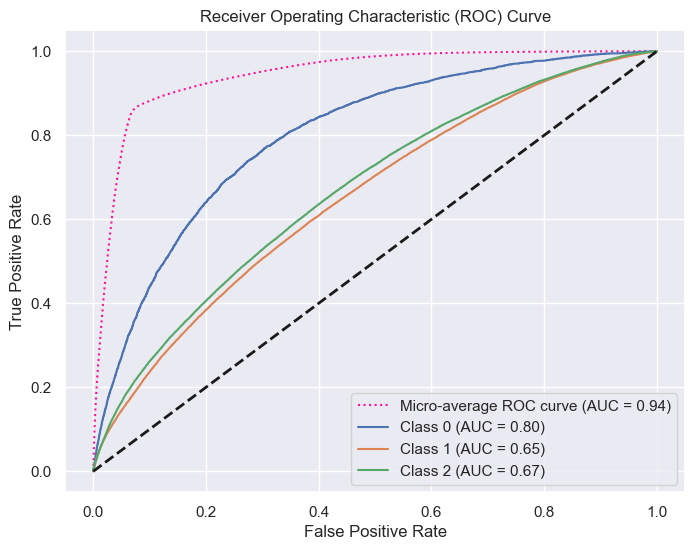

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Assuming x_train_ann, y_train_ann, x_test_ann, y_test_ann are your training and testing data
# Assuming num_classes is defined

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_ann, num_classes=3)
y_test_one_hot = to_categorical(y_test_ann, num_classes=3)

# Build and train your neural network (ann_model3)
# ...

# Make predictions on the test set
y_pred_ann = ann_model3.predict(x_test_ann)
y_score = y_pred_ann

# For binary or multilabel classification, you need to binarize the labels
if num_classes > 2:
    y_test_one_hot = label_binarize(y_test_ann, classes=range(3))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':')

# Plot each class's ROC curve
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
